## Walmart 상품판매량 예측
- stores.csv : 45개 상점의 크기와 타입 기재.
- train.csv : 각 컬럼은 다음과 같음.
    - Store (스토어를 나타내는 숫자)
    - Dept (부서를 나타내는 숫자)
    - Date (날짜)
    - Weekly_Sales (부서별 주간 판매량)
    - IsHoliday (공휴일 포함 유무)
- test.csv : Weekly_sales를 제외하곤 train.csv와 동일. 이 파일에서 Weekly_sales를 예측하는것이 목적.
- features.csv : 추가적인 feature들의 정보 포함.
    - Store (스토어 숫자)
    - Date (날짜)
    - Temperature (상점이 위치한 지역의 평균 온도)
    - Fuel_Price (상점이 위치한 지역의 기름값)
    - MarkDown1-5 (프로모션 데이터. NA 존재)
    - CPI (소비자 물가지수)
    - Unemployment (실업률)
    - IsHoliday (공휴일이 포함된 주인지 아닌지 의미)
- 각 주요 공유일에 해당하는 날짜는 다음과 같음.
    * Super Bowl : 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
    * Labor Day : 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
    * Thanksgiving : 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
    * Christmas : 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

sns.set()
%matplotlib inline

In [3]:
features = pd.read_csv('UseData/walmart-recruiting-store-sales-forecasting/features.csv')
train = pd.read_csv('UseData/walmart-recruiting-store-sales-forecasting/train.csv')
stores = pd.read_csv('UseData/walmart-recruiting-store-sales-forecasting/stores.csv')
test = pd.read_csv('UseData/walmart-recruiting-store-sales-forecasting/test.csv')
sample_submission = pd.read_csv('UseData/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv')

**feature.csv와 stores.csv를 merge해서 새로운 데이터셋 feat_sto를 생성. Key는 'Store' Column.**

In [4]:
# key = Store를 기준으로 INNER JOIN.
feat_sto = features.merge(stores, how='inner', on='Store')

In [5]:
# 새로 생성한 DF를 한번 둘러보자.
feat_sto.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [6]:
feat_sto.dtypes

Store             int64
Date             object
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday          bool
Type             object
Size              int64
dtype: object

    지금 보면 Date가 object로 되어있음. datetime으로 변경해야 함.

In [7]:
# Pandas에 있는 to_datetime()을 이용해 형식을 변환한다.
feat_sto.Date = pd.to_datetime(feat_sto.Date)
train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)

**'Date'로부터 Week와 Year column을 새로 추가.**

In [8]:
# datetime객체에 사용 가능한 연산 dt.week // dt.year 이용.
feat_sto['Week'] = feat_sto.Date.dt.week
feat_sto['Year'] = feat_sto.Date.dt.year

C:\Users\skdbs\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [9]:
# 바꾸고 추가한 DF를 한번 확인해보자.
feat_sto

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Week,Year
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,5,2010
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315,6,2010
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315,7,2010
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315,8,2010
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315,9,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False,B,118221,26,2013
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False,B,118221,27,2013
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False,B,118221,28,2013
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False,B,118221,29,2013


**train과 feat_sto, test와 feat_sto를 묶어 train_detail, test_detail이라는 새로운 DF를 생성.**

In [11]:
# key = ['Store', 'Date', 'IsHoliday']를 기준으로 INNER JOIN.
# JOIN한 값들은 ['Store', 'Dept', 'Date']를 기준으로 sort.
train_detail = train.merge(feat_sto,
                          how='inner',
                          on=['Store', 'Date', 'IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

In [12]:
# train_detail과 마찬가지로 JOIN 후 sort.
test_detail = test.merge(feat_sto,
                        how='inner',
                        on=['Store', 'Date', 'IsHoliday']).sort_values(by=['Store',
                                                                          'Dept',
                                                                          'Date']).reset_index(drop=True)

In [13]:
# 합쳐진걸 한번 확인해보자.
train_detail

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week,Year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,5,2010
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,6,2010
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,7,2010
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,8,2010
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315,9,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221,39,2012
421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,B,118221,40,2012
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,B,118221,41,2012
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,B,118221,42,2012


**연도별, 날짜별 판매량을 그래프로 그려보자**

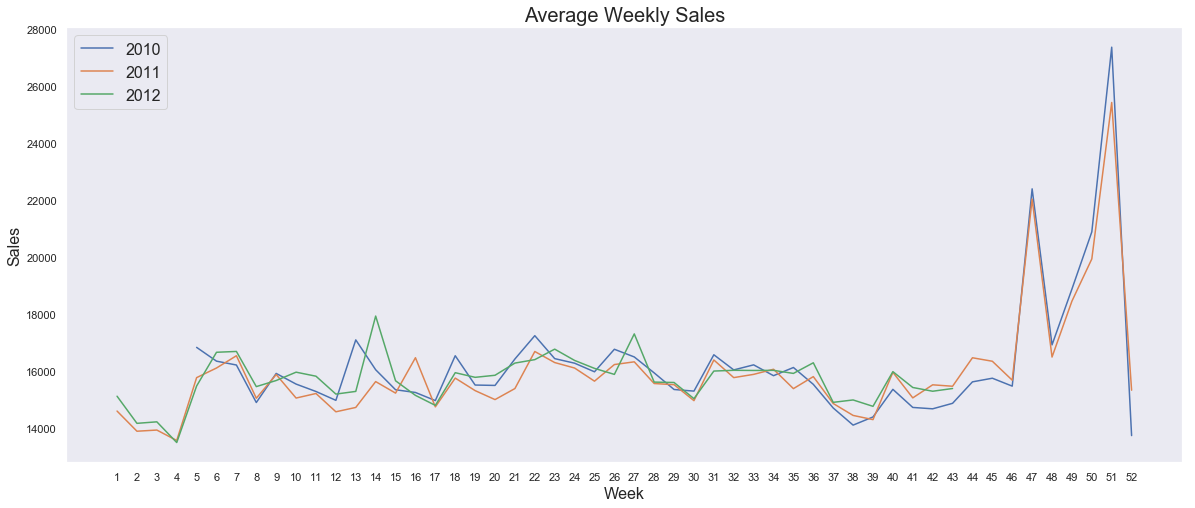

In [15]:
# Week를 기준으로 groupby연산을 통해 주차별 판매량의 평균을 나타내는 형태로 변환.
weekly_sales_2010 = train_detail[train_detail.Year==2010]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2011 = train_detail[train_detail.Year==2011]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2012 = train_detail[train_detail.Year==2012]['Weekly_Sales'].groupby(train_detail['Week']).mean()

plt.figure(figsize=(20,8))

# 변환한 DF를 lineplot으로 시각화.
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)
plt.grid()

plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales', fontsize=20)
plt.xlabel('Week', fontsize=16)
plt.ylabel('Sales', fontsize=16)
plt.show()

     잘 보면 끝 주차에 판매량이 압도적으로 높아짐.
     이때는 연말. 크리스마스가 겹치는 시기.
      
     그 외에도 주요 공휴일 기간엔 판매량이 좀 더 높아지는 것을 확인할 수 있다.

**날짜별 판매량의 평균, 중앙값 구해보기**

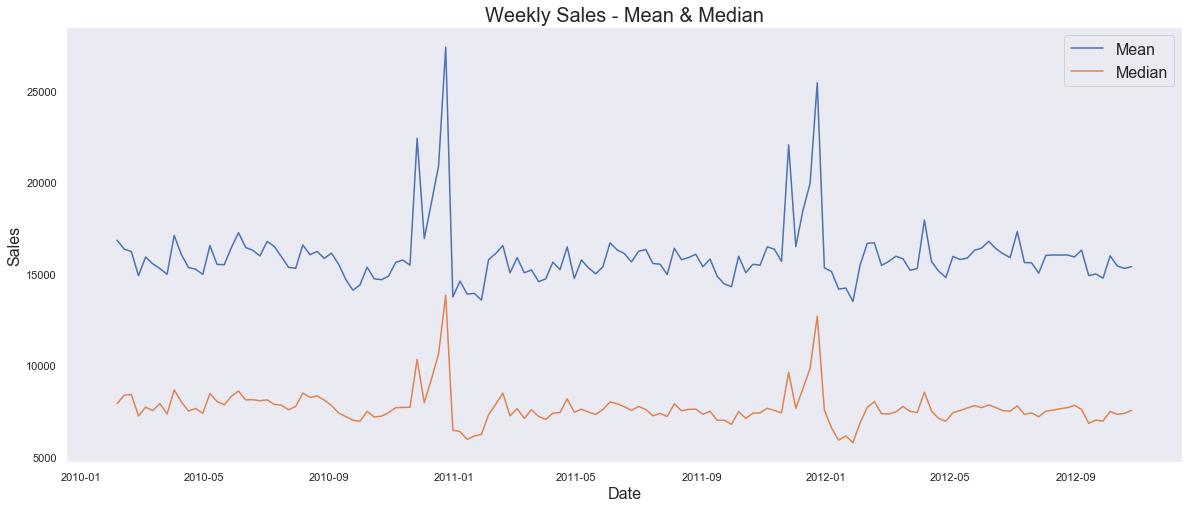

In [16]:
# Weekly Sales를 Date에 따라 groupby 한 후, mean/median을 구함.
weekly_sales_mean = train_detail['Weekly_Sales'].groupby(train_detail['Date']).mean()
weekly_sales_median = train_detail['Weekly_Sales'].groupby(train_detail['Date']).median()

plt.figure(figsize=(20,8))

sns.lineplot(weekly_sales_mean.index, weekly_sales_mean.values)
sns.lineplot(weekly_sales_median.index, weekly_sales_median.values)
plt.grid()

plt.legend(['Mean', 'Median'], loc='best', fontsize=16)
plt.title('Weekly Sales - Mean & Median', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Sales', fontsize=16)
plt.show()

    마찬가지로, 연말의 판매량이 껑충 뛰는걸 확인할 수 있음.
- 또한, 평균과 중앙값의 Sales값 차이가 좀 많이 남.
    - **어떤 상점(Store)/부서(Department)는 다른 곳보다 훨씬 많이/적게 판매한다**는 사실을 유추해 볼 수 있음.

**상점(Store)과 부서(Department)별 평균 판매량(Average Sales)을 살펴보자.**

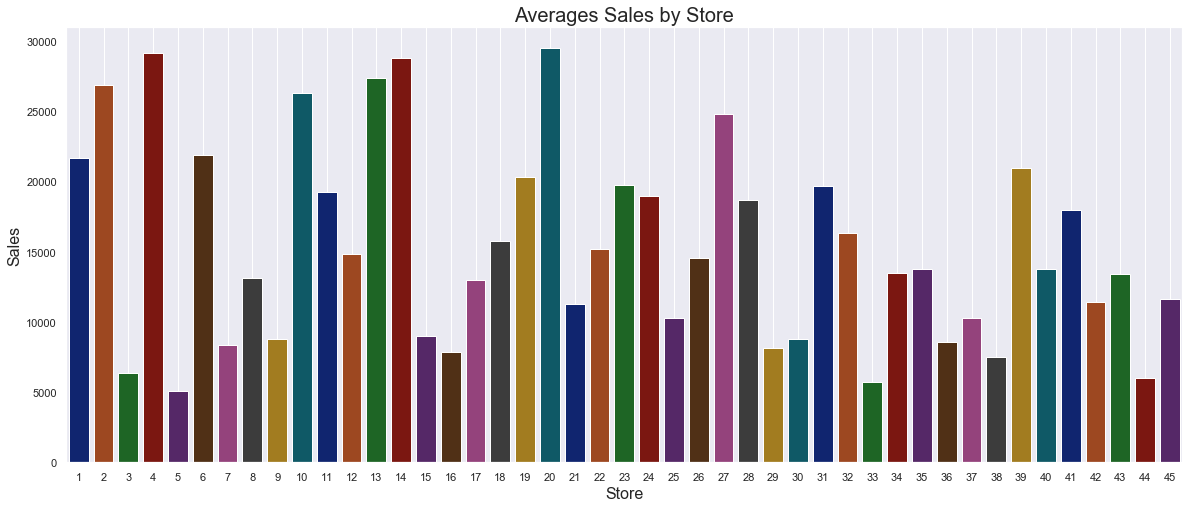

In [18]:
# 이번엔 'Date'로의 그루핑이 아닌 Store로 그루핑.
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Store']).mean()

plt.figure(figsize=(20, 8))

sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()

plt.title('Averages Sales by Store', fontsize=20)
plt.xlabel('Store', fontsize=16)
plt.ylabel('Sales', fontsize=16)
plt.show()

    실제로 상점별 판매량이 크게 차이나는 것을 확인할 수 있다.

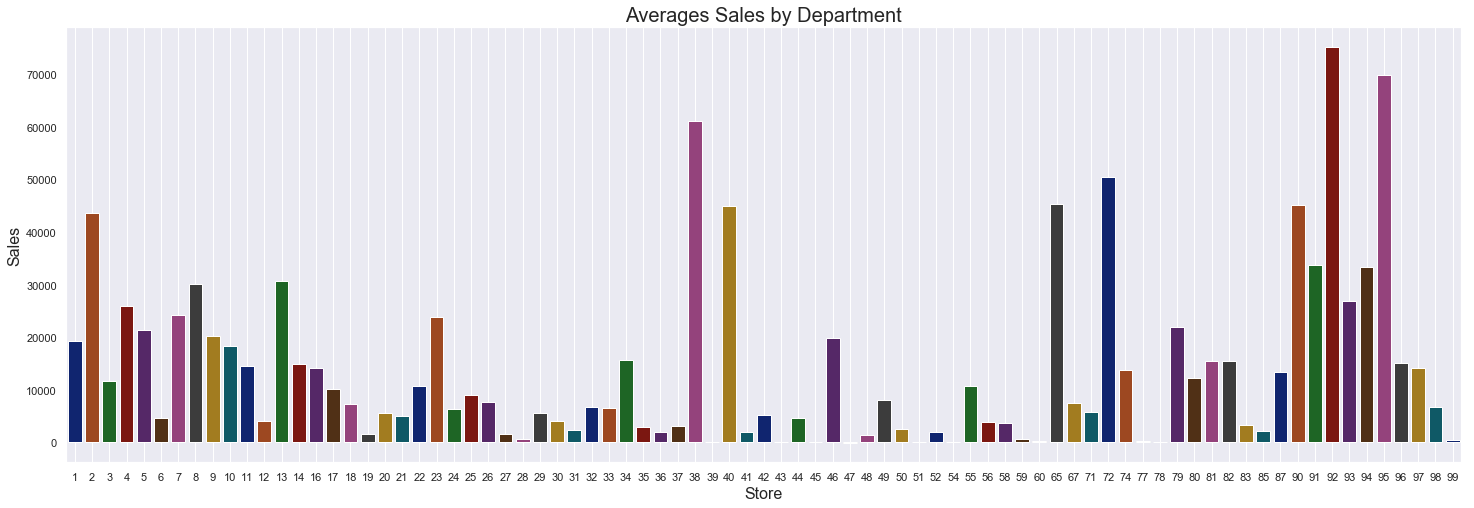

In [20]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Dept']).mean()

plt.figure(figsize=(25, 8))

sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()

plt.title('Averages Sales by Department', fontsize=20)
plt.xlabel('Store', fontsize=16)
plt.ylabel('Sales', fontsize=16)
plt.show()

    마찬가지로 부서별 판매량 또한 차이나는 것을 확인할 수 있다.

### Correlation Analysis

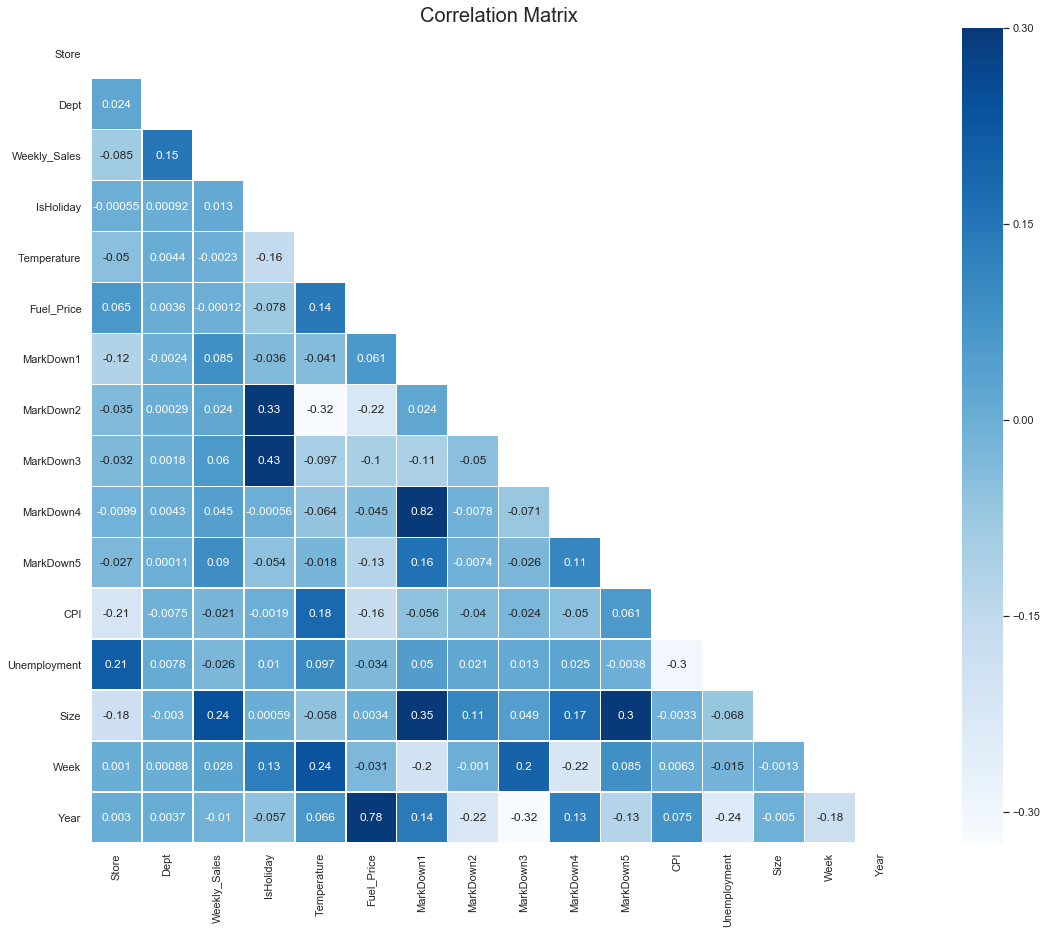

In [27]:
sns.set(style='white')
corr = train_detail.corr()
# np.triu : 상삼각행렬 반환. 
mask = np.triu(np.ones_like(corr, dtype=np.bool))
fig, ax = plt.subplots(figsize=(20, 15))
# cmap = sns.diverging_palette(220, 10, as_cmap=True) # 왜 오류뜨지?
# https://github.com/mwaskom/seaborn/issues/1907
# 높은 numpy버전에서 안돌아간다함. 다운그레이드 하고 sns 업데이트 하면 된다고는 함...

plt.title('Correlation Matrix', fontsize=20)
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidth=.5, annot=True)
sns.heatmap(corr, mask=mask, cmap='Blues', vmax=.3, center=0, square=True, linewidth=.5, annot=True)

plt.show()

Weekly_Sales와 연관이 높은 변수가 있을까? Size.<br>

**MarkDown1~5와 Fuel_price는 Weekly_Sales와 큰 연관을 갖는다 보기가 좀 힘듬. Drop하자.**

In [28]:
train_detail = train_detail.drop(columns=['Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])
test_detail = test_detail.drop(columns=['Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])

In [29]:
train_detail

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,CPI,Unemployment,Type,Size,Week,Year
0,1,1,2010-02-05,24924.50,False,42.31,211.096358,8.106,A,151315,5,2010
1,1,1,2010-02-12,46039.49,True,38.51,211.242170,8.106,A,151315,6,2010
2,1,1,2010-02-19,41595.55,False,39.93,211.289143,8.106,A,151315,7,2010
3,1,1,2010-02-26,19403.54,False,46.63,211.319643,8.106,A,151315,8,2010
4,1,1,2010-03-05,21827.90,False,46.50,211.350143,8.106,A,151315,9,2010
...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,192.013558,8.684,B,118221,39,2012
421566,45,98,2012-10-05,628.10,False,64.89,192.170412,8.667,B,118221,40,2012
421567,45,98,2012-10-12,1061.02,False,54.47,192.327265,8.667,B,118221,41,2012
421568,45,98,2012-10-19,760.01,False,56.47,192.330854,8.667,B,118221,42,2012


Detail한 분석을 위해 Feature를 좀 더 자세히 분석해보자. <br>
<br>
- **함수**를 만들어 그래프를 그려보자

    - discrete plot : boxplot, stripplot을 이용해 이산형 수치를 가진 column을 시각화.
    - continuous plot : scatterplot을 이용해 연속형 수치를 가진 column을 시각화.


In [33]:
def make_discrete_plot(feature) :
    fig = plt.figure(figsize=(20, 8))
    gs = GridSpec(1, 2)
    
    sns.boxplot(y = train_detail.Weekly_Sales, x = train_detail[feature], ax = fig.add_subplot(gs[0,0]))
    plt.xlabel(feature, fontsize=16)
    plt.ylabel('Sales', fontsize=16)
    
    sns.stripplot(y = train_detail.Weekly_Sales, x = train_detail[feature], ax = fig.add_subplot(gs[0,1]))
    plt.xlabel(feature, fontsize=16)
    plt.ylabel('Sales', fontsize=16)
    
    fig.show()

In [34]:
def make_continuous_plot(feature) :
    fig = plt.figure(figsize=(18, 15))
    sns.scatterplot(data = train_detail, x = feature, y = 'Weekly_Sales', color='green')
    fig.show()

**작성한 함수를 이용해 Weekly_Sales와 다른 컬럼의 관계를 한번 둘러보자.**

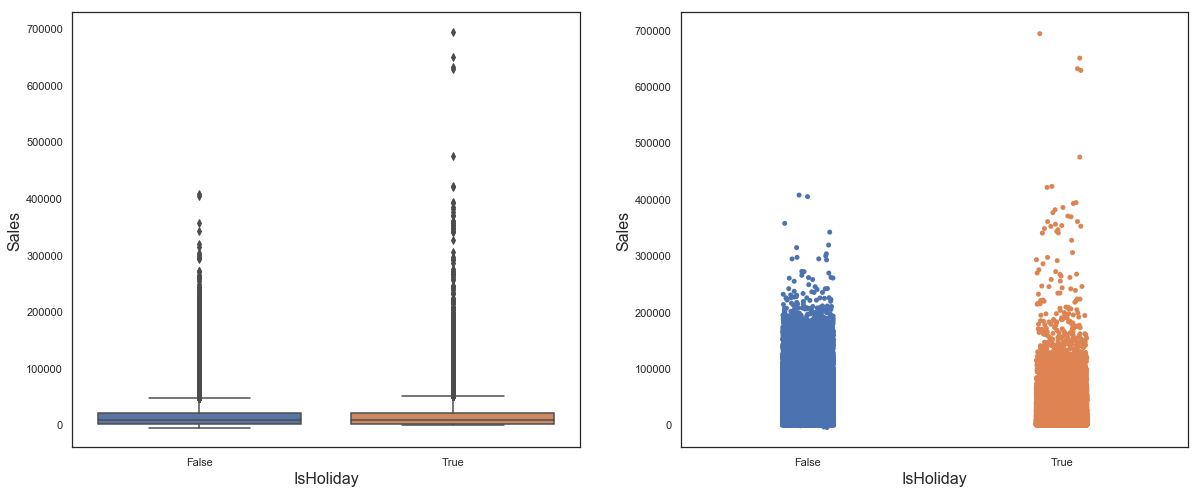

In [35]:
# Weekly_Sales와 IsHoliday의 관계는 어떨까?
make_discrete_plot('IsHoliday')

    공휴일이 포함된 주의 판매량이 좀 더 높은것을 확인할 수 있음.

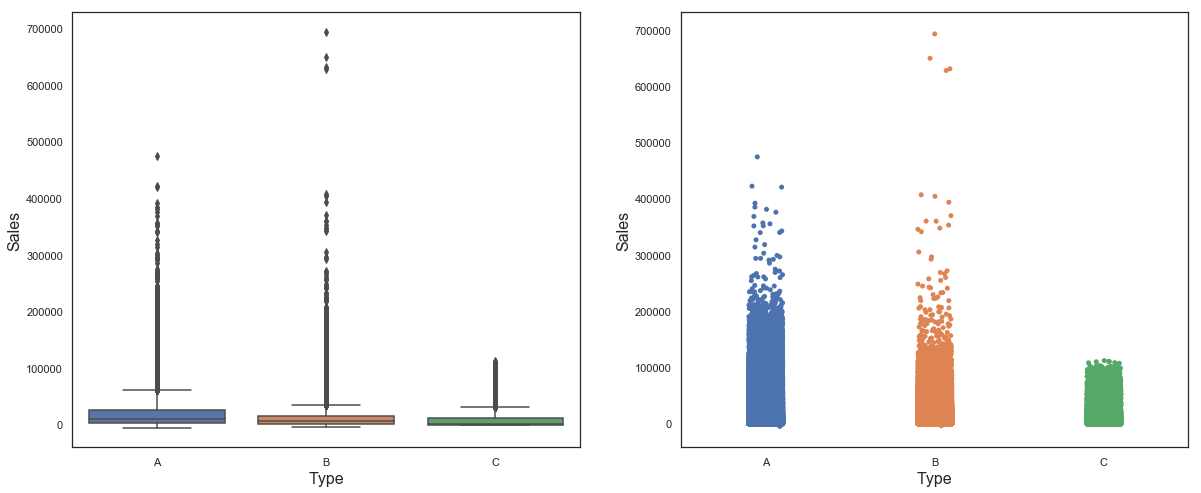

In [36]:
# Weekly_Sales와 Type의 관계는 어떨까?
make_discrete_plot('Type')

    상점 유형에 따라서도 판매량의 차이가 있는 것을 확인할 수 있음.

**이런 A,B,C 같은 string 타입은 ML모델이 처리를 할 수 없음.**
- Ordinal type (순서형 데이터)로 바꿔준다.

In [37]:
# lambda 표현식을 이용해 한줄로 간편하게.
train_detail.Type = train_detail.Type.apply(lambda x : 3 if x == 'A' else(2 if x == 'B' else 1))
test_detail.Type = test_detail.Type.apply(lambda x : 3 if x == 'A' else(2 if x == 'B' else 1))

C:\Users\skdbs\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


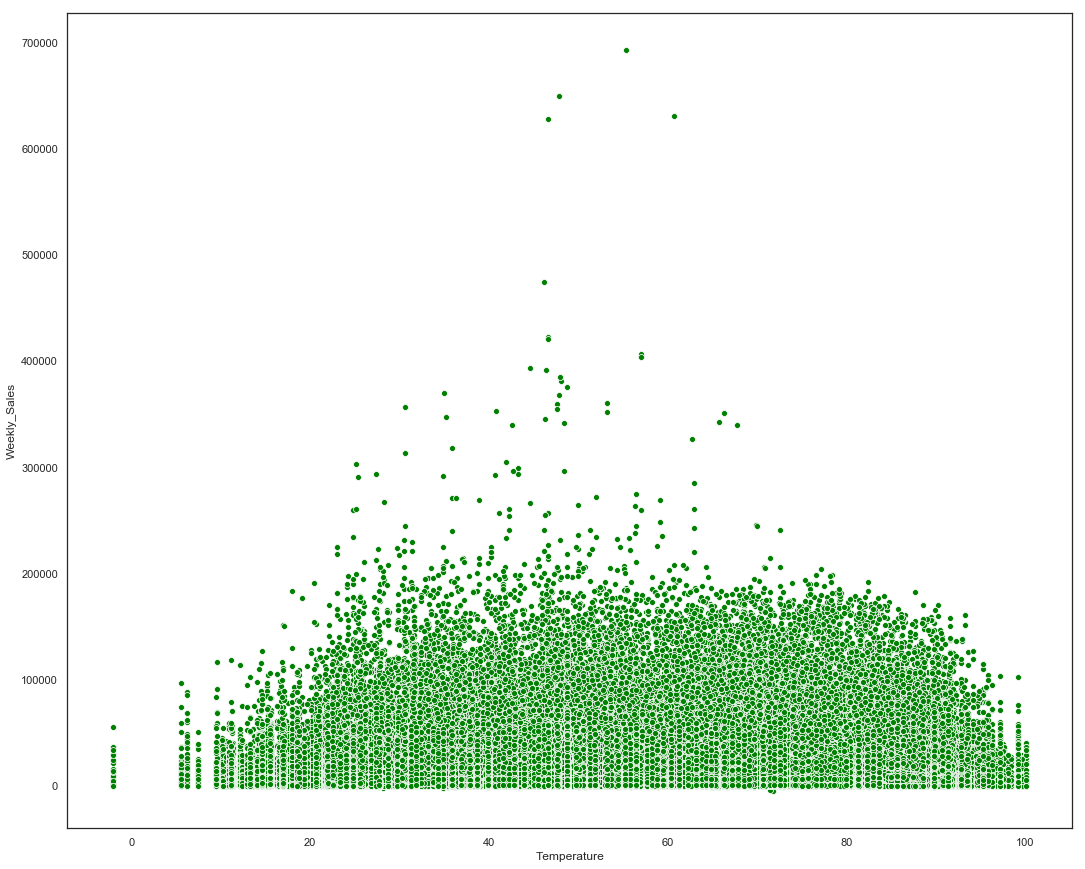

In [38]:
# Weekly_Sales와 Temperature의 관계는 어떨까?
make_continuous_plot('Temperature')

    온도와 판매량은 큰 연관이 없어보인다. Drop.

In [39]:
train_detail = train_detail.drop(columns=['Temperature'])
test_detail = test_detail.drop(columns=['Temperature'])

C:\Users\skdbs\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


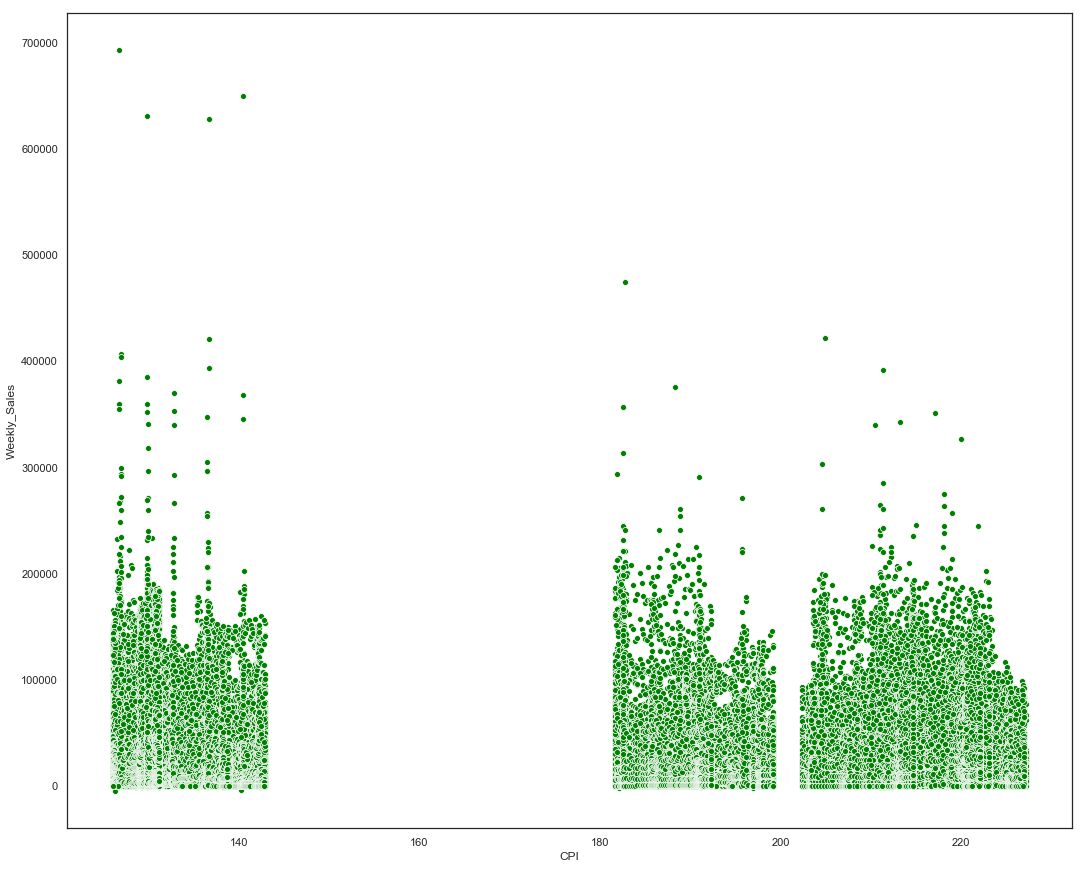

In [40]:
# Weekly_Sales와 CPI의 관계는 어떨까?
make_continuous_plot('CPI')

    마찬가지로 큰 연관이 없어보임. Drop.
    

In [41]:
train_detail = train_detail.drop(columns=['CPI'])
test_detail = test_detail.drop(columns=['CPI'])

C:\Users\skdbs\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


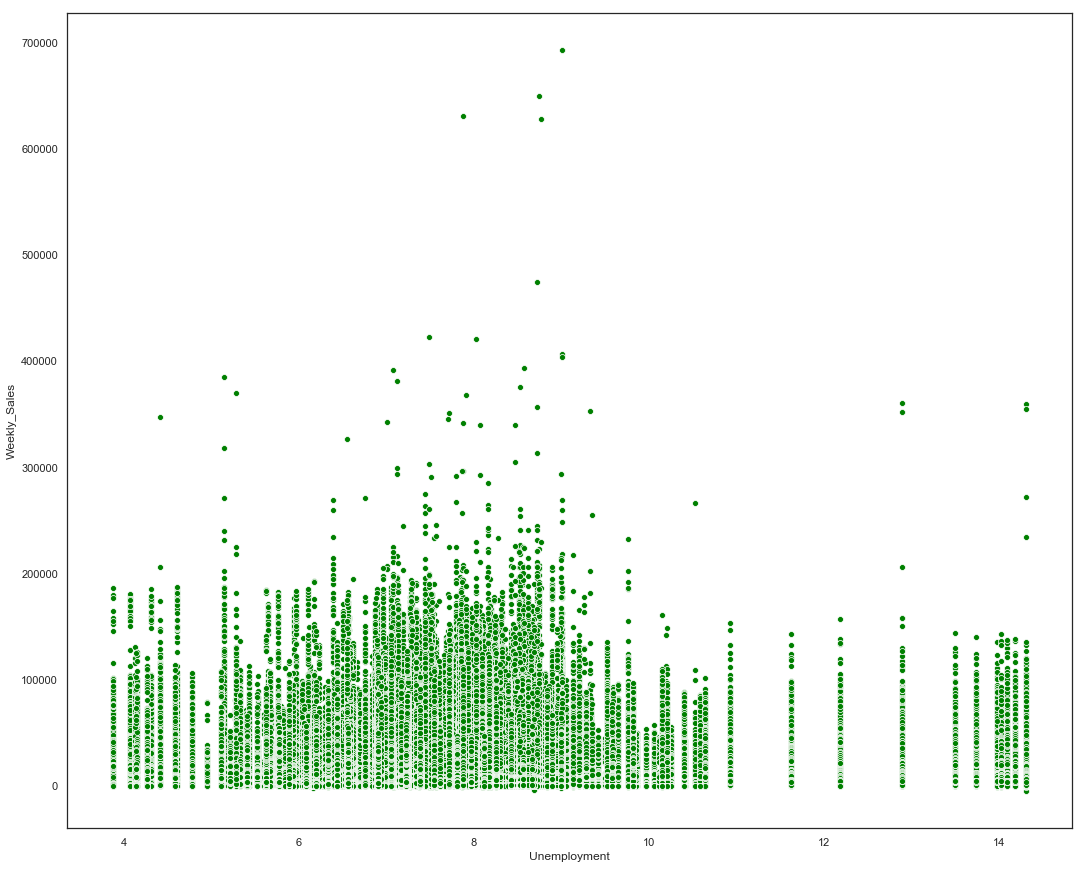

In [42]:
# Weekly_Sales와 Unemployment의 관계는 어떨까?
make_continuous_plot('Unemployment')

    이거도 큰 연관이 없어보인다. Drop.

In [43]:
train_detail = train_detail.drop(columns=['Unemployment'])
test_detail = test_detail.drop(columns=['Unemployment'])

C:\Users\skdbs\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


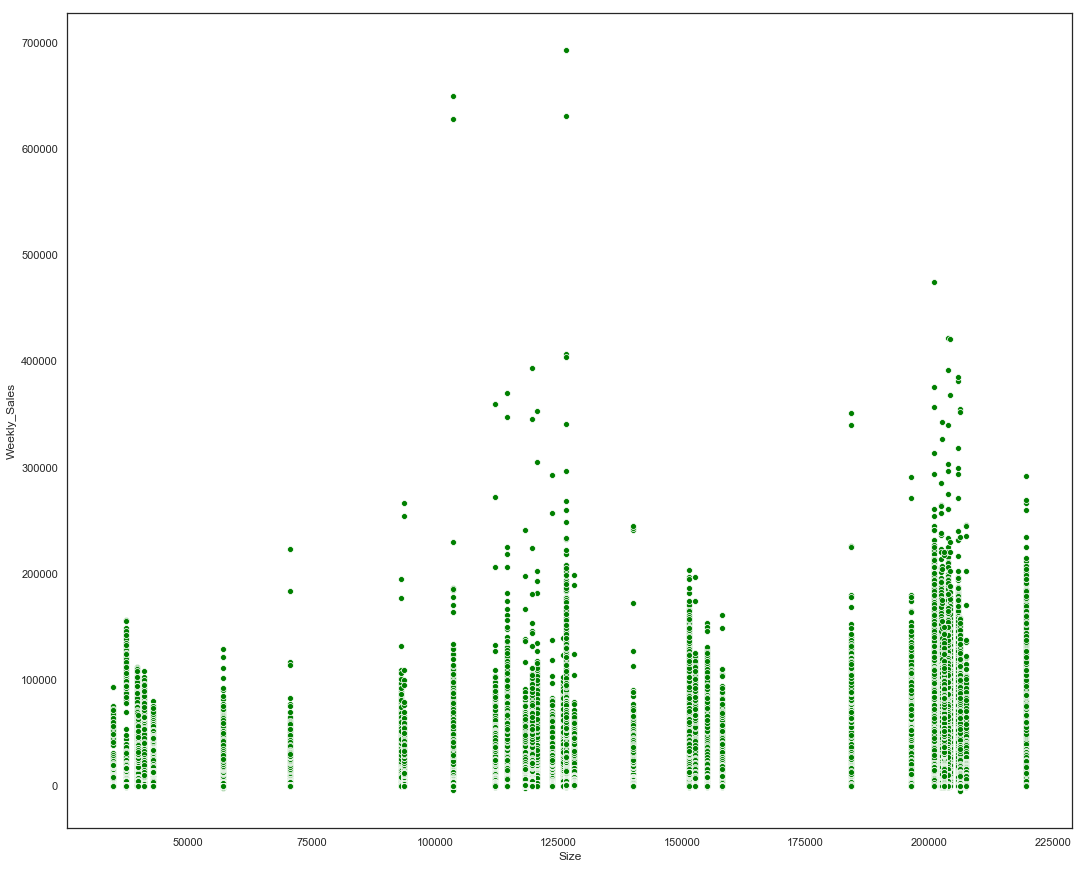

In [44]:
# 마지막으로, Weekly_Sales와 Size는 관계가 어떨까?
make_continuous_plot('Size')

    얼핏 보면 연관관계가 없어보임.
    근데, 잘 보면 size가 커질수록 증가하는 추세선이 나타날 수 있음.

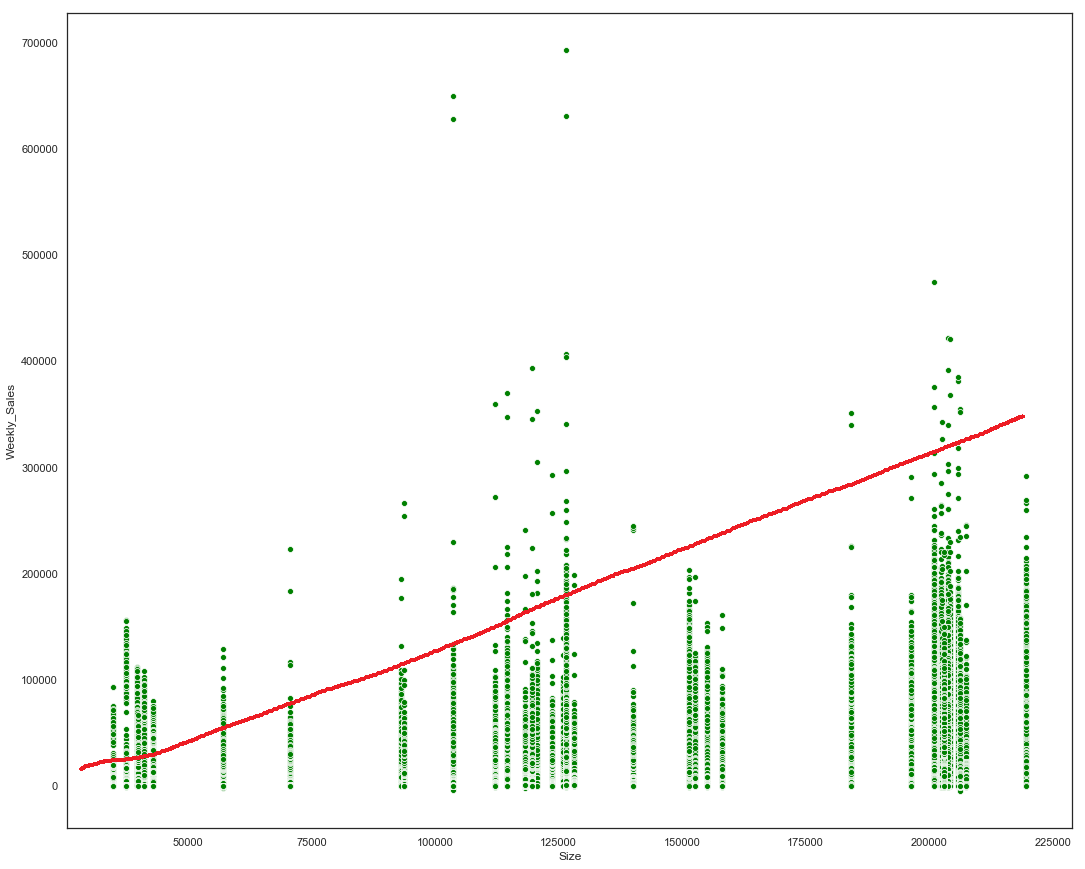
    **이런식으로.**

In [45]:
# 제거들을 마친 후 어떤 특성들만 남았을까?
test_detail

,Store,Dept,Date,IsHoliday,Type,Size,Week,Year
0,1,1,2012-11-02,False,3,151315,44,2012
1,1,1,2012-11-09,False,3,151315,45,2012
2,1,1,2012-11-16,False,3,151315,46,2012
3,1,1,2012-11-23,True,3,151315,47,2012
4,1,1,2012-11-30,False,3,151315,48,2012
...,...,...,...,...,...,...,...,...
115059,45,98,2013-06-28,False,2,118221,26,2013
115060,45,98,2013-07-05,False,2,118221,27,2013
115061,45,98,2013-07-12,False,2,118221,28,2013
115062,45,98,2013-07-19,False,2,118221,29,2013


**18개의 차원이 8개의 차원으로 줄어들었다! 어떻게 보면 노가다 성 차원축소...**

## ML을 이용한 예측모델 생성
    공휴일을 포함한 주에 5의 가중치를 두고 WMAE를 계산한다.

**따라서, 사용할 WMAE 손실함수는 다음과 같이 정의할 수 있다.**
<br>
- scikit learn에서 WMAE를 제공하긴 하지만, 우리는 조금 변형된 형태를 사용하므로 정의가 필요.

In [53]:
def WMAE(dataset, real, predicted) :
    # 공휴일인 경우 5의 가중치를 주고, 아닌경우 1의 가중치를 줌.
    weights = dataset.IsHoliday.apply(lambda x : 5 if x else 1)
    
    return np.round(np.sum(weights * abs(real - predicted)) / (np.sum(weights)), 2)

**RandomForestRegressor 활용**

In [47]:
X_train = train_detail[['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Type', 'Year']]
Y_train = train_detail['Weekly_Sales']

In [49]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2)
RanForest = RandomForestRegressor()
RanForest.fit(x_train, y_train)
predicted = RanForest.predict(x_test)

**Train Error 측정**

In [54]:
print('WMAE : ', WMAE(x_test, y_test, predicted))

WMAE :  1485.49


**이제 test data에 대해 예측을 수행해보자.**

In [55]:
X_test = test_detail[['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Type', 'Year']]
predict = RanForest.predict(X_test)

## 제출용 csv 데이터 합치기

In [57]:
sample_submission.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,0
1,1_1_2012-11-09,0
2,1_1_2012-11-16,0
3,1_1_2012-11-23,0
4,1_1_2012-11-30,0


**비어있는 Weekly_Sales에 우리가 예측한 값을 넣어주면 된다.**

In [58]:
sample_submission['Weekly_Sales'] = predict
sample_submission.to_csv('exampleSubmission.csv', index=False)

In [59]:
sample_submission

,Id,Weekly_Sales
0,1_1_2012-11-02,33204.6184
1,1_1_2012-11-09,20743.9860
2,1_1_2012-11-16,20794.7535
3,1_1_2012-11-23,20936.0336
4,1_1_2012-11-30,25064.5674
...,...,...
115059,45_98_2013-06-28,675.0757
115060,45_98_2013-07-05,672.2822
115061,45_98_2013-07-12,674.0829
115062,45_98_2013-07-19,630.2324


    이렇게 생성한 csv파일을 제출하면 대회에 참가하게 되는 셈.

<Figure size 1800x576 with 0 Axes>

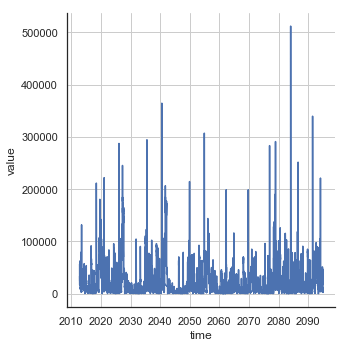

In [74]:

# 한번 얼마나 에측했는지 봐볼까?
# 데이터가 너무 크니 조금만 짤라서 보자.
# newX = sample_submission['Weekly_Sales'].iloc[:30000]
# newY = sample_submission['Id'].iloc[:30000]
"""
sns.lineplot(x = sample_submission['Weekly_Sales'].iloc[:30000],
             y = sample_submission.index(start=0, stop=30000, step=1))
plt.title('Forecast of my model')
"""
# Id를 임의로 바꿔보자.
newDf = pd.DataFrame(dict(time=pd.date_range('2012-11-02', periods=30000),
                         value=sample_submission['Weekly_Sales'].iloc[:30000]))
plt.figure(figsize=(25,8))
sns.relplot(data=newDf, x = 'time', y = 'value', kind='line')
plt.grid()
plt.show()
# 음 뭔가좀 내가 원하는 형태가 아니다